<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/08_intro__to_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

- Downloading a text dataset
- Visualizing text data
- Converting text into numbers using tokenization
- Turning our tokenized text into an embedding
- Modelling a text dataset
- Starting with a baseline (TF-IDF)
- Building several deep learning text models
- Dense, LSTM, GRU, Conv1D, Transfer learning
- Comparing the performance of each our models
- Combining our models into an ensemble
- Saving and loading a trained model
- Find the most wrong predictions

### Download helper functions and libararies

In [1]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-07-18 09:43:50--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-07-18 09:43:50 (111 MB/s) - ‘helper_functions.py’ saved [11016/11016]



In [146]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Activation, GlobalAveragePooling1D, Flatten, LSTM, GRU, Bidirectional, Conv1D
from helper_functions import plot_confusion_matrix, plot_loss_curves, classes_names, plot_pictures, create_tf_board_callback, unzip_file, compare_historys, walk_through_dir

### Download dataset from Kaggle

We'll be using the Real or Not? datset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about diasters, for example:
'Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano'

The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote


In [3]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_file("nlp_getting_started.zip")

--2021-07-18 09:43:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-07-18 09:43:53 (151 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
df_test = pd.read_csv('/content/test.csv')
df_train = pd.read_csv('/content/train.csv')

In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
len(df_test), len(df_train)

(3263, 7613)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df_test.keyword.unique(), df_train.keyword.unique()

(array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
        'ambulance', 'annihilated', 'annihilation', 'apocalypse',
        'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
        'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
        'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
        'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
        'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
        'buildings%20burning', 'buildings%20on%20fire', 'burned',
        'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
        'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
        'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
        'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
        'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
        'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       

Remove special characters and Nan from keywords

In [10]:
df_test = df_test.fillna('')  
df_train = df_train.fillna('') 
df_test.keyword = df_test.keyword.apply(lambda x: x.replace('%20', ' ') )
df_train.keyword = df_train.keyword.apply(lambda x: x.replace('%20', ' ') )

### Check the length of our twits

In [11]:
seq_len = [[len(i.split()), k] for i, k in zip(df_train.text, df_train.target)]

In [12]:
df_viz = pd.DataFrame(seq_len, columns = ['number_of_tokens', 'target'])

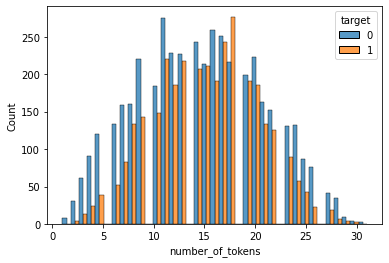

In [13]:
sns.histplot(df_viz, x = 'number_of_tokens', hue = 'target', multiple="dodge")

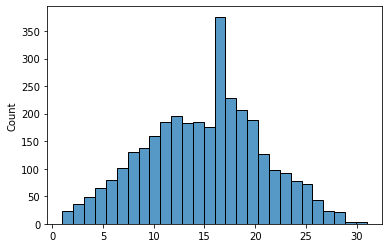

In [14]:
seq_len = [len(i.split()) for i in df_test.text]
sns.histplot(pd.Series(seq_len), )

### Shuffle our data 

In [15]:
df_train = df_train.sample(frac=1, random_state=42)

### Check if dataset is balanced

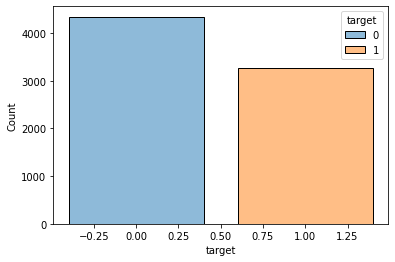

In [16]:
sns.histplot(df_train, x = 'target', hue = 'target', discrete=True, shrink=.8)

### Visualize random tweets


In [17]:
import random
random_index = random.randint(0, len(df_train)-5)
for row in df_train[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
My blood pressure is through the roof I don't need all this extra shit!!!!

---

Target: 0 (not real disaster)
Text:
Reddit Will Now Quarantine Offensive Content: Reddit co-founder and CEO Steve Huffman has unveiled more specif... http://t.co/T7gE0j3CAy

---

Target: 0 (not real disaster)
Text:
Ronda Rousey would be 'close' to making Floyd Mayweather's money in 50 fights - Bloody Elbow http://t.co/IjzcYtbFfo #boxing

---

Target: 0 (not real disaster)
Text:
@Camilla_33 @CrayKain Hate to shatter your delusions but a hatchet is a deadly weapon justifying lethal force. #gunsense

---

Target: 0 (not real disaster)
Text:
'The harder the conflict the more glorious the triumph.' Thomas Paine

---



In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_train.text.to_numpy(), df_train.target.to_numpy(), test_size = 0.1, random_state = 42)

In [19]:
X_test = df_test.text.to_numpy()

In [20]:
X_train[:10], y_train[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Remove links to the accounts, html links, numbers

In [21]:
def remove_links(X):
  X_ = []
  for text in X:
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http://.+\s*', '', text)
    text = re.sub(r'https://.+\s*', '', text)
    text = re.sub(r'\d+', '', text)
    X_.append(text)
  return X_

In [22]:
X_train = remove_links(X_train)
X_val = remove_links(X_val)
X_test = remove_links(X_test)

In [23]:
X_train[:10]

['  i screamed after hitting tweet',
 'Imagine getting flattened by Kurt Zouma',
 ' #MSGDoingWelfareWorks Green S welfare force ke appx  members har time disaster victim ki help ke liye tyar hai....',
 "   im shaking in fear he's gonna hack the planet",
 'Somehow find you and I collide ',
 '  great times until the bus driver held us hostage in the mall parking lot lmfao',
 'destroy the free fandom honestly',
 'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense ',
 ' Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
 'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery ']

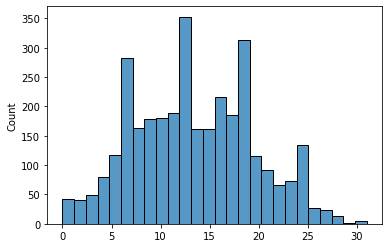

In [24]:
seq_len = [len(i.split()) for i in X_test]
sns.histplot(pd.Series(seq_len))

### Convert text to numbers

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [34]:
tokens = 30 # Sequence length to pad the outputs to. I choose max length
vocab_length = 10000 # Maximum vocab size

In [35]:
#Create vectorization layer
text_vect = TextVectorization(max_tokens = vocab_length, 
                              standardize = 'lower_and_strip_punctuation', 
                              ngrams = None, 
                              split = 'whitespace',
                              output_sequence_length = tokens, 
                              pad_to_max_tokens=False, 
                              vocabulary=None,
                              output_mode = 'int')

In [36]:
text_vect.adapt(X_train)

In [37]:
text_vect([' great times until the bus driver held us hostage in the mall parking lot lmfao'])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[ 184,  238,  290,    2,  355,  860, 1986,   67,  493,    4,    2,
        2717, 2654,  486, 2734,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

### Get unique words in sentences (vocab)

In [38]:
text_vect.vocabulary_size()

10000

In [39]:
words_in_vocab = text_vect.get_vocabulary()

In [40]:
words_in_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

In [41]:
words_in_vocab[-5:]

['kebabtahinipickles', 'kdr', 'kcrw', 'kckh', 'kc']

### Create embedding

Turns positive integers (indexes) into dense vectors of fixed size.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

`tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)`

This layer can only be used as the first layer in a model.

In [43]:
from tensorflow.keras.layers import Embedding

In [44]:
embedding = Embedding(input_dim = vocab_length,
                      output_dim = 128, #better if can divide by 6
                      embeddings_initializer='uniform', 
                      embeddings_regularizer=None, 
                      activity_regularizer=None, 
                      embeddings_constraint=None, 
                      mask_zero = False, 
                      input_length = tokens)

In [45]:
random_tweet = random.choice(X_train)
print(f'Original: {random_tweet}\n')
print(f'Vectorized: {text_vect([random_tweet])}\n')
print(f'Embedded: {embedding(text_vect([random_tweet]))}')

Original: they say bad things happen for a reason
but no wise words gonna stop te bleeding

Vectorized: [[  61  125  272  406 1230   10    3  730   31   41 6063  614  302  230
  4129  564    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]

Embedded: [[[ 0.04457771 -0.00233207  0.00286661 ... -0.0087974   0.02111837
   -0.00335975]
  [-0.04178905  0.01412599 -0.02546591 ...  0.03472276 -0.004739
   -0.01525911]
  [ 0.00310478  0.01877525  0.01549676 ... -0.02347156 -0.01521864
   -0.04973707]
  ...
  [ 0.00858792  0.01235658  0.02190775 ...  0.04049632 -0.01708956
   -0.00760628]
  [ 0.00858792  0.01235658  0.02190775 ...  0.04049632 -0.01708956
   -0.00760628]
  [ 0.00858792  0.01235658  0.02190775 ...  0.04049632 -0.01708956
   -0.00760628]]]


In [46]:
embedding(text_vect([random_tweet])).shape

TensorShape([1, 30, 128])

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.


To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.


More specifically, we'll be building the following:


- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

### Model 0: Naive Bayes (baseline)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support

In [48]:
model_0 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB())])

In [49]:
model_0.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('mnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [50]:
base_pred = model_0.predict(X_val)

In [51]:
base_val_accuracy = accuracy_score(y_val, base_pred )
base_val_accuracy

0.7965879265091863

In [52]:
base_val_precision = precision_score(y_val, base_pred )
base_val_precision

0.8844621513944223

#### Save results to results_df

In [53]:
results_df = pd.DataFrame(columns = ['num_experiment','model_name', 'accuracy_score', 'precision', 'racall', 'f-1_score'])

In [54]:
def write_result(y_pred, model_name, y_val = y_val):
  global results_df
  #another way
  # precision, racall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average = 'weights')
  results_df.loc[len(results_df)] = [len(results_df),
                                     model_name, 
                                     accuracy_score(y_val, y_pred), 
                                     precision_score(y_val, y_pred),
                                     recall_score(y_val, y_pred),
                                     f1_score(y_val, y_pred)
                                     ]

In [55]:
write_result(base_pred, 'base_naive_bayes')

In [56]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235


In [57]:
base_conf_matr = confusion_matrix(y_val, base_pred)

In [58]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model1: Feed-forward neural network (dense model)

#### Create Tensorflow Board callback

In [59]:
DIR = 'model_logs'
#create_tf_board_callback()

In [60]:
inputs = Input(shape = (1,), dtype=tf.string)
x = text_vect(inputs)
x = embedding(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs =  Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs, outputs)

In [61]:
model_1.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [62]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                245824    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,525,889
Trainable params: 1,525,889
Non-trainable params: 0
___________________________________________________

In [63]:
history_1 = model_1.fit(tf.constant(X_train), y_train, 
             epochs = 5,
            validation_data = (tf.constant(X_val), y_val),
            callbacks = create_tf_board_callback(DIR, 'model_1'))

Saving TensorBoard log files to model_logs/model_1/20210718-095049
Epoch 1/5
215/215 [==============================] - 7s 18ms/step - loss: 0.5650 - accuracy: 0.7094 - val_loss: 0.4800 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2671 - accuracy: 0.9009 - val_loss: 0.5481 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1203 - accuracy: 0.9616 - val_loss: 0.5861 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0847 - accuracy: 0.9698 - val_loss: 0.6866 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0628 - accuracy: 0.9714 - val_loss: 0.7812 - val_accuracy: 0.7546


In [64]:
prob_1 = model_1.predict(tf.constant(X_val))

In [65]:
prob_1.shape

(762, 1)

In [66]:
pred_1 = tf.round(tf.squeeze(prob_1))

In [67]:
pred_1[:10], y_val[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [68]:
write_result(pred_1, 'base_dense_model_1')

In [69]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900


In [71]:
model1_conf_matr = confusion_matrix(y_val, pred_1)
model1_conf_matr

array([[359,  55],
       [132, 216]])

In [87]:
base_conf_matr

array([[385,  29],
       [126, 222]])

#### Build base model as in tutorial: add GlobalAveragePooling1D() and remove Dense(128) 5 epochs

In [72]:
from tensorflow.keras import backend as K

In [73]:
K.clear_session()

In [74]:
#I replace Flatten layer to GAP, run for 5 epochs 
inputs = Input(shape = (1,), dtype=tf.string)
x = text_vect(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x) 
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [75]:
model_1_2 = Model(inputs, outputs)

In [76]:
model_1_2.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [77]:
model_1_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
___________________________________________________

In [78]:
history_1_2 = model_1_2.fit(tf.constant(X_train), y_train,
                        epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_1_2'))

Saving TensorBoard log files to model_logs/model_1_2/20210718-095849
Epoch 1/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4769 - accuracy: 0.8253 - val_loss: 0.4731 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2825 - accuracy: 0.8879 - val_loss: 0.4990 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2110 - accuracy: 0.9207 - val_loss: 0.5645 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1625 - accuracy: 0.9402 - val_loss: 0.6181 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1363 - accuracy: 0.9494 - val_loss: 0.6620 - val_accuracy: 0.7690


In [79]:
prob_1_2 = model_1_2.predict(tf.constant(X_val))

In [80]:
prob_1_2.shape

(762, 1)

In [81]:
pred_1_2 = np.round(prob_1_2).flatten()

In [82]:
pred_1_2[:10], y_val[:10]

(array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [83]:
write_result(pred_1_2, 'simple_dense_model_1_2')

In [84]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900
2,2,simple_dense_model_1_2,0.769029,0.777419,0.692529,0.732523


In [86]:
model1_2_conf_matr = confusion_matrix(y_val, pred_1_2)
model1_2_conf_matr

array([[345,  69],
       [107, 241]])

In [88]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Visualise learned Embedding

In [89]:
model_1_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
___________________________________________________

In [90]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vect.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'i', 'and', 'is'])

In [91]:
embed_weights = model_1_2.get_layer('embedding').get_weights()[0]

In [92]:
embed_weights

array([[ 0.01712697, -0.03152036,  0.04287122, ..., -0.00943492,
        -0.06001188, -0.04228797],
       [ 0.05131322, -0.04614005,  0.10134701, ..., -0.04148512,
        -0.00959499, -0.04149962],
       [ 0.06330501, -0.03567011,  0.03234107, ..., -0.02938011,
        -0.0101509 , -0.07514248],
       ...,
       [-0.04582889, -0.04044246, -0.00625622, ...,  0.03291857,
        -0.01804018, -0.02130038],
       [-0.0407124 , -0.0105462 ,  0.02924868, ...,  0.01854316,
         0.0156048 ,  0.0016351 ],
       [ 0.05275933,  0.11831407, -0.00312346, ..., -0.10551866,
         0.02856588, -0.05690886]], dtype=float32)

Now we've got these two objects, we can use the Embedding Projector tool to visualize our embedding.

To use the Embedding Projector tool, we need two files:
- The embedding vectors (same as embedding weights).
- The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to use the code example available on the TensorFlow word embeddings tutorial page.

https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk

In [93]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [94]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).
For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:
Massive earthquake last week, no?
No massive earthquake last week.
Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
- One to one: one input, one output, such as image classification.
- One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
- Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
- Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
- Long short-term memory cells (LSTMs).
- Gated recurrent units (GRUs).
- Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

### Model2 LSTM
`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
`

In [95]:
K.clear_session()

In [101]:
inputs = Input(shape = (1,), dtype = tf.string)
x = text_vect(inputs)
x = embedding(x)
x = LSTM(units = 64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [102]:
model_2 = Model(inputs, outputs)

In [103]:
model_2.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [104]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65  

In [105]:
history_2 = model_2.fit(tf.constant(X_train), y_train,
                        epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_2'))

Saving TensorBoard log files to model_logs/model_2/20210718-100526
Epoch 1/5
215/215 [==============================] - 12s 27ms/step - loss: 0.1920 - accuracy: 0.9197 - val_loss: 0.6314 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1089 - accuracy: 0.9622 - val_loss: 0.9528 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0889 - accuracy: 0.9669 - val_loss: 1.1043 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0800 - accuracy: 0.9679 - val_loss: 0.8400 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0762 - accuracy: 0.9682 - val_loss: 0.9617 - val_accuracy: 0.7664


In [106]:
prob_2 = model_2.predict(tf.constant(X_val))

In [107]:
prob_2.shape

(762, 1)

In [108]:
pred_2 = np.round(prob_2).flatten()

In [109]:
pred_2[:10], y_val[:10]

(array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [110]:
write_result(pred_2, 'LSTM_model_2')

In [111]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900
2,2,simple_dense_model_1_2,0.769029,0.777419,0.692529,0.732523
3,3,LSTM_model_2,0.766404,0.775974,0.686782,0.728659


In [112]:
model2_conf_matr = confusion_matrix(y_val, pred_2)
model2_conf_matr

array([[345,  69],
       [109, 239]])

In [114]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model3 GRU
The GRU cell has similar features to an LSTM cell but has less parameters.


In [115]:
inputs = Input(shape = (1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = GRU(64, return_sequences=True)(x)
x = LSTM(64, return_sequences = True)(x)
x = GRU(64)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [116]:
model_3 = Model(inputs, outputs)

In [117]:
model_3.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 30, 64)            37248     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160

In [118]:
history_3 = model_3.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_3'))

Saving TensorBoard log files to model_logs/model_3/20210718-100753
Epoch 1/5
215/215 [==============================] - 10s 29ms/step - loss: 0.1668 - accuracy: 0.9301 - val_loss: 1.2417 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0920 - accuracy: 0.9673 - val_loss: 1.1443 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0733 - accuracy: 0.9683 - val_loss: 1.0972 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0696 - accuracy: 0.9710 - val_loss: 1.0345 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0615 - accuracy: 0.9717 - val_loss: 1.4018 - val_accuracy: 0.7559


In [119]:
prob_3 = model_3.predict(tf.constant(X_val))

In [120]:
prob_3.shape

(762, 1)

In [121]:
pred_3 = np.round(prob_3).flatten()

In [122]:
pred_3[:10], y_val[:10]

(array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [123]:
write_result(pred_3, 'GRU_model_3')

In [124]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900
2,2,simple_dense_model_1_2,0.769029,0.777419,0.692529,0.732523
3,3,LSTM_model_2,0.766404,0.775974,0.686782,0.728659
4,4,GRU_model_3,0.755906,0.791367,0.632184,0.702875


In [125]:
model3_conf_matr = confusion_matrix(y_val, pred_3)
model3_conf_matr

array([[356,  58],
       [128, 220]])

In [126]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model4 Bidirectional LSTM(RNN)

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

In [135]:
inputs = Input(shape = (1,), dtype='string')
x = text_vect(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences = True))(x)
x = Bidirectional(GRU(64))(x)
x = Dense(64)(x)
outputs = Dense(1, activation='sigmoid')(x)

In [136]:
model_4 = Model(inputs, outputs)

In [137]:
model_4.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')


In [138]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65  

In [139]:
history_4 = model_4.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_4'))

Saving TensorBoard log files to model_logs/model_4/20210718-101454
Epoch 1/5
215/215 [==============================] - 12s 34ms/step - loss: 0.1072 - accuracy: 0.9587 - val_loss: 1.2284 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0641 - accuracy: 0.9701 - val_loss: 1.5306 - val_accuracy: 0.7507
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0612 - accuracy: 0.9707 - val_loss: 1.7331 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0542 - accuracy: 0.9737 - val_loss: 1.5725 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0541 - accuracy: 0.9734 - val_loss: 1.6923 - val_accuracy: 0.7493


In [140]:
prob_4 = model_4.predict(tf.constant(X_val))

In [141]:
pred_4 = np.round(prob_4).flatten()

In [142]:
write_result(pred_4, 'Bidirectional_model_4')

In [143]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900
2,2,simple_dense_model_1_2,0.769029,0.777419,0.692529,0.732523
3,3,LSTM_model_2,0.766404,0.775974,0.686782,0.728659
4,4,GRU_model_3,0.755906,0.791367,0.632184,0.702875
5,5,Bidirectional_model_4,0.749344,0.785455,0.620690,0.693419


In [144]:
model4_conf_matr = confusion_matrix(y_val, pred_4)
model4_conf_matr

array([[355,  59],
       [132, 216]])

In [145]:
base_conf_matr

array([[385,  29],
       [126, 222]])

### Model 5 1D Convolutional Neural Network

In [147]:
K.clear_session()

In [153]:
inputs = Input((1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation= 'sigmoid')(x)

In [154]:
model_5 = Model(inputs, outputs)

In [159]:
model_5.compile(optimizer='adam', metrics='accuracy', loss = 'binary_crossentropy')

In [160]:
model_5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            12320     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65  

In [169]:
history_5 = model_5.fit(tf.constant(X_train), y_train, epochs = 5,
                        validation_data = (tf.constant(X_val), y_val),
                        callbacks = create_tf_board_callback(DIR, 'model_5'))

Saving TensorBoard log files to model_logs/model_5/20210718-105113
Epoch 1/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0385 - accuracy: 0.9800 - val_loss: 3.1092 - val_accuracy: 0.7310
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0420 - accuracy: 0.9796 - val_loss: 3.0481 - val_accuracy: 0.7283
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0382 - accuracy: 0.9799 - val_loss: 3.2379 - val_accuracy: 0.7297
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0377 - accuracy: 0.9801 - val_loss: 3.2980 - val_accuracy: 0.7310
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0374 - accuracy: 0.9807 - val_loss: 3.3867 - val_accuracy: 0.7283


In [162]:
prob_5 = model_5.predict(tf.constant(X_val))

In [163]:
pred_5 = np.round(prob_5).flatten()

In [164]:
write_result(pred_5, 'Conv1D_model_5')

In [165]:
results_df

,num_experiment,model_name,accuracy_score,precision,racall,f-1_score
0,0,base_naive_bayes,0.796588,0.884462,0.637931,0.741235
1,1,base_dense_model_1,0.754593,0.797048,0.620690,0.697900
2,2,simple_dense_model_1_2,0.769029,0.777419,0.692529,0.732523
3,3,LSTM_model_2,0.766404,0.775974,0.686782,0.728659
4,4,GRU_model_3,0.755906,0.791367,0.632184,0.702875
5,5,Bidirectional_model_4,0.749344,0.785455,0.620690,0.693419
6,6,Conv1D_model_5,0.744094,0.744409,0.669540,0.704992


In [166]:
model5_conf_matr = confusion_matrix(y_val, pred_5)
model5_conf_matr

array([[334,  80],
       [115, 233]])

In [167]:
base_conf_matr

array([[385,  29],
       [126, 222]])